# **Feature Extractor**

In [1]:
from google.colab import drive
drive.mount('./drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [2]:
from keras import models

class feature_extractor():
    
    def load_model(self):
    
    
    with open('drive/My Drive/dataset/model_arch.yaml', 'r') as yaml_file:
        model_arch = yaml_file.read()

  
    model_1 = models.model_from_yaml(model_arch)
    model_1.load_weights('drive/My Drive/dataset/model_weights.hdf5')
    
    
    # removing output Dense layer (which containing 7 neurons)
    model_1.pop()
    
   
    
    return(model_1)

Using TensorFlow backend.


# **DataSet Loader**

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image
from keras.utils import to_categorical


In [0]:
X_train = np.load('drive/My Drive/dataset/X_train.npy')
Y_train = np.load('drive/My Drive/dataset/y_train.npy')

In [0]:
os.mkdir('images')

for i in range(X_train.shape[0]):
    img = X_train[i].reshape(50,37)
    filename = 'images'+'/train_Img_'+ str(i+1) + '.png'
    plt.imsave(filename,img)

In [ ]:
train_imgs = os.listdir('images')
reshaped_train_imgs = []

for img_name in train_imgs:
    file_dir = 'images/' + img_name
    img = image.load_img(file_dir,target_size=(224,224))
    img = image.img_to_array(img)
    reshaped_train_imgs.append(img)
  
  
train_x = np.stack(reshaped_train_imgs)  #--stacking up the images into batches
train_y = to_categorical(Y_train)        #---one hot encoding of the labels

In [6]:
data_reshaped = train_x.reshape((966,224*224*3))
df = pd.DataFrame(data_reshaped)

df['label'] = Y_train

df.head()

,0,1,2,3,4,5,6,7,8,9,...,150519,150520,150521,150522,150523,150524,150525,150526,150527,label
0,49.0,100.0,141.0,49.0,100.0,141.0,49.0,100.0,141.0,49.0,...,36.0,170.0,130.0,36.0,170.0,130.0,36.0,170.0,130.0,5
1,30.0,153.0,138.0,30.0,153.0,138.0,30.0,153.0,138.0,30.0,...,36.0,170.0,130.0,36.0,170.0,130.0,36.0,170.0,130.0,0
2,52.0,95.0,141.0,52.0,95.0,141.0,52.0,95.0,141.0,52.0,...,71.0,38.0,118.0,71.0,38.0,118.0,71.0,38.0,118.0,2
3,69.0,52.0,127.0,69.0,52.0,127.0,69.0,52.0,127.0,69.0,...,246.0,230.0,31.0,246.0,230.0,31.0,246.0,230.0,31.0,3
4,71.0,192.0,110.0,71.0,192.0,110.0,71.0,192.0,110.0,71.0,...,207.0,225.0,28.0,207.0,225.0,28.0,207.0,225.0,28.0,5


In [0]:
def dataset(group,class_num):
    model_1 = feature_extractor().load_model()
 
    feature_vectors = []


    for i in range(0,class_num):  
        desired_df = df[df['label']==i]
        random_index = np.random.randint(low=0,high=desired_df.shape[0],size=(1,group))

        data = desired_df.iloc[random_index[0], :-1]

        data = np.array(data).reshape(group,224,224,3)
        pred_arr = model_1.predict_on_batch(data)

        feature_vectors.append(pred_arr)

    
    feature_vector_arr = np.concatenate(feature_vectors) 
    labels_arr = np.arange(class_num, dtype='int')
  
    return(feature_vector_arr, labels_arr)
  

# **Aggregation Module (Contain Attention Block)**

In [0]:
batch_size= 7 #--7 different unique images
feature_len= 128  #--128-d feature vector 
class_num= 7  #--total 7 class in output
group= 5   #--taking 5 images for each person
 
import tensorflow as tf
import time


input_x = tf.placeholder(tf.float32, shape = [batch_size*group, feature_len])
label_x = tf.placeholder(tf.int32, shape = [batch_size, class_num]) 

In [0]:
w1 = tf.get_variable("fc1/weights", shape = [feature_len, feature_len], initializer = tf.random_normal_initializer(mean = 0.0, stddev = 1e-4))
b1  = tf.get_variable("fc1/biases", shape = [feature_len], initializer = tf.constant_initializer(0.0001))
w2 = tf.get_variable("fc2/weights", shape = [feature_len, class_num], initializer = tf.random_normal_initializer(mean = 0.0, stddev = 1e-4))
b2 = tf.get_variable("fc2/biases", shape = [class_num], initializer = tf.constant_initializer(0.0001))
q_param = tf.get_variable("q0", shape = [feature_len], initializer = tf.constant_initializer(0.0001))




#attention module 1
resize_input = input_x  #--35x128
expand_param = tf.expand_dims(q_param, 1)  # 128x1

temp = tf.matmul(resize_input, expand_param)  #--35x1
temp = tf.reshape(temp, [batch_size, group])  #--7x5
temp = tf.nn.softmax(temp)  #--7x5
features = tf.split(axis = 0, num_or_size_splits = batch_size, value = input_x)  #--list of 7 elements of size 5x128
temps = tf.split(axis = 0, num_or_size_splits = batch_size, value = temp)   #--list of 7 elements of size 1x5
fusion = [tf.matmul(temps[i], features[i]) for i in range(batch_size)] #list of 7 elements of size 1x128
r1 = tf.concat(axis = 0, values = fusion)  #--7x128

#fc1 layer
fc = tf.add(tf.matmul(r1, w1), b1, name = "fc1")  #--7x128
tanh = tf.nn.tanh(fc)  #--7x128


#attention module 2
input_split = tf.split(axis = 0, num_or_size_splits = batch_size, value = input_x)  #--list of 7 elements of size 5x128
q1_split = tf.split(axis = 0, num_or_size_splits = batch_size, value = tanh)  #--list of 7 elements of size 1x128(different kernel for each elements)
q1_split = tf.reshape(q1_split, shape=[7,128,1])   #--change to 128x1
a1 = [tf.tensordot(features[i], q1_split[i], 1) for i in range(batch_size)]   #--list of 7 elements of size 5x1
a1_fusion = tf.concat(axis = 0, values = a1)      #--35x1
e1 = tf.nn.softmax(a1_fusion)   #--35x1
temp1 = tf.split(axis = 0, num_or_size_splits = batch_size, value = e1)   #--list of 7 elements of size 1x5
fusion1 = [tf.matmul(temps[i], features[i]) for i in range(batch_size)]  #--list of 7 elements of size 1x128
r2 = tf.concat(axis = 0, values = fusion)  #--7x128

#fc2 layer
predict = tf.add(tf.matmul(r2, w2), b2, name = "predict")  #--7x7(predicted output)
# return r2, predict

In [13]:
static = tf.equal(tf.argmax(predict, 1), tf.argmax(label_x, 1))
accuracy = tf.reduce_mean(tf.cast(static, tf.float32))

loss = tf.nn.softmax_cross_entropy_with_logits(labels = label_x, logits = predict)
loss = tf.reduce_mean(loss)
optim = tf.train.RMSPropOptimizer(learning_rate = 0.01).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
epoch=200
LossValues = []
iterations = []

for i in range(epoch):
    feature_vector_arr, labels_arr = dataset(group,class_num)
    labels_arr = to_categorical(labels_arr)
    _ = sess.run([optim], feed_dict={input_x:feature_vector_arr, label_x:labels_arr})
  
    meanCrossEntropyLossValue = sess.run(loss, feed_dict={input_x:feature_vector_arr, label_x:labels_arr})
 
    LossValues.append(meanCrossEntropyLossValue)
    iterations.append((i+1))
  
    print("The value of Mean Cross Entropy Loss in Epoch # {} is {}".format((i+1),meanCrossEntropyLossValue))

  

The value of Mean Cross Entropy Loss in Epoch # 1 is 1.842853307723999
The value of Mean Cross Entropy Loss in Epoch # 2 is 1.8240020275115967
The value of Mean Cross Entropy Loss in Epoch # 3 is 1.816138505935669
The value of Mean Cross Entropy Loss in Epoch # 4 is 1.7800935506820679
The value of Mean Cross Entropy Loss in Epoch # 5 is 1.7758151292800903
The value of Mean Cross Entropy Loss in Epoch # 6 is 1.7783681154251099
The value of Mean Cross Entropy Loss in Epoch # 7 is 1.7754805088043213
The value of Mean Cross Entropy Loss in Epoch # 8 is 1.7311550378799438
The value of Mean Cross Entropy Loss in Epoch # 9 is 1.7652714252471924
The value of Mean Cross Entropy Loss in Epoch # 10 is 1.7289308309555054
The value of Mean Cross Entropy Loss in Epoch # 11 is 1.791880488395691
The value of Mean Cross Entropy Loss in Epoch # 12 is 1.5937230587005615
The value of Mean Cross Entropy Loss in Epoch # 13 is 1.6936575174331665
The value of Mean Cross Entropy Loss in Epoch # 14 is 1.6446781

In [17]:
acc = sess.run(accuracy,feed_dict={input_x:feature_vector_arr,label_x:labels_arr})
print('Accuracy of Aggregation Module:',acc)

Accuracy of Aggregation Module: 1.0


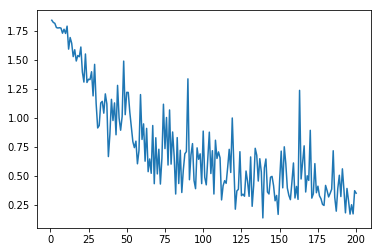

In [18]:
import matplotlib.pyplot as plt
plt.plot(iterations,LossValues)